# **JOB RECOMENDATION MODEL**

Model that will be use to help a job seeker find a job based on their skill and region

This model using TensorFlow, CNN, and other library or data computation and training to teach the model.


### **1st Step: Install the Library**
Instal all the library that needed in this model to start using it

We using `Pandas`, `NumPy`, `TensorFlow`, and `matplotlib.pyplot`

Also `TensorFlow`, `Keras`, and `sklearn`

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity

## **2nd Step: Get The Dataset**
Get the dataset from GitHub

We need 3 dataset such as `job_offer.csv`, `company.csv`, `regency.csv`

3 dataset that contain dummy data to train the model


In [7]:
# 2. Get the dataset from GitHub
job_offer_df = pd.read_csv('https://raw.githubusercontent.com/MadRapz/Machine-Learning-PEMUDA/refs/heads/main/Dataset/job_offer9.csv')
company_df = pd.read_csv('https://raw.githubusercontent.com/MadRapz/Machine-Learning-PEMUDA/refs/heads/main/Dataset/company.csv')
regency_df = pd.read_csv('https://raw.githubusercontent.com/MadRapz/Machine-Learning-PEMUDA/refs/heads/main/Dataset/regency.csv')

## **3rd Step: Merge dataset and collumn**

Enhance the `job_offer_df` dataset by adding `regency_name` from `regency_df` and transforming the `req_skill` column for better usability.

Create a new column, `combined_text`, which combines skills (`req_skill`) and location (`regency_name`).

In [8]:
# 3. Merge dataset and collumn
# Merge job_offer_df with regency_df to get regency_name based on id_regency
job_offer_df = job_offer_df.merge(regency_df[['id_regency', 'regency_name']], how='left', on='id_regency')

# If req_skill collumn data is a list, convert it into string with comma seperated
job_offer_df['req_skill'] = job_offer_df['req_skill'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# Make a combined_text collumn that combine req_skill and regency_name
job_offer_df['combined_text'] = job_offer_df['req_skill'].fillna('') + ' ' + job_offer_df['regency_name'].fillna('')

# Show few data after merging
print(job_offer_df[['position', 'req_skill', 'regency_name', 'combined_text']].head())

            position                                          req_skill  \
0     UI/UX Designer  Figma , Adobe XD , Sketch, HTML , CSS , Typogr...   
1  Marketing Manager  Strategic Thinking, Digital Marketing Expertis...   
2  Software Engineer  Software Architecture , Design Patterns, Java,...   
3        QA Engineer  Testing Frameworks Selenium , Testing Framewor...   
4  Software Engineer  Software Architecture , Design Patterns, Java,...   

  regency_name                                      combined_text  
0   Karangasem  Figma , Adobe XD , Sketch, HTML , CSS , Typogr...  
1     Jembrana  Strategic Thinking, Digital Marketing Expertis...  
2     Jembrana  Software Architecture , Design Patterns, Java,...  
3      Gianyar  Testing Frameworks Selenium , Testing Framewor...  
4      Gianyar  Software Architecture , Design Patterns, Java,...  


After that the output will show some of the data that have been merge into `combined_text`

<br><br>
## **4th Step: Tokenization and Padding**
To process the textual data in the `combined_text` column for use in machine learning models by converting text into numerical representations and ensuring uniform sequence length through padding.



In [10]:
# 3. Tokenization and Padding
# Initialize a tokenizer object to process the text data
tokenizer = Tokenizer()

# Fit the tokenizer on the text data from the 'combined_text' column of the DataFrame
tokenizer.fit_on_texts(job_offer_df['combined_text'])

# Convert the text data into sequences of integers using the tokenizer
# Each text in combined_text is converted into a sequence of integers
# where each integer corresponds to a word in the tokenizer’s vocabulary.
sequences = tokenizer.texts_to_sequences(job_offer_df['combined_text'])

# Define the maximum sequence length for padding (determined to be 27 after inspecting the data)
max_len = 27

# Pad the sequences to ensure they all have the same length (27 in this case)
# Padding is applied to the end of each sequence ('post' padding)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Display the first 5 padded sequences for verification
print(padded_sequences[:5])

[[ 37   9  38  39   5   6  40  41  42  43   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [ 53  18  54  55  56  19  33  57  58  59  60  61  62   2  32   2  34  63
    2  64  65   2  47   0   0   0   0]
 [ 21 111 112 113   4 114  12  12   3  14   6   5  10  27   1  23 115 116
   47   0   0   0   0   0   0   0   0]
 [  1   8  66   1   8  67  68   1  69   1  70  71  72  73  18  26   0   0
    0   0   0   0   0   0   0   0   0]
 [ 21 111 112 113   4 114  12  12   3  14   6   5  10  27   1  23 115 116
   26   0   0   0   0   0   0   0   0]]


## **5th Step: Build a Neural Network**
Build a neural network model that takes skills and regency as inputs, processes them with embedding layers, and predicts job similarity.

It combines skill and regency data, flattens them, and passes them through dense layers to produce a binary prediction.

In [5]:
# 5. Building a Neural Network Model

embedding_dim = 100  # Size of the embedding layer

# Define input layers for skill and regency with sequences of tokens as input
input_skill = Input(shape=(max_len,), name='skill_input')
input_regency = Input(shape=(max_len,), name='regency_input')

# Create an embedding layer for skill and regency inputs
# This layer converts tokenized input into dense vector representations
embedding_layer = Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    input_length=max_len
    )

# Apply the embedding layer to the skill and regency inputs
embedded_skill = embedding_layer(input_skill)
embedded_regency = embedding_layer(input_regency)

# Flatten the embedded skill and regency tensors into 1D vectors
flattened_skill = Flatten()(embedded_skill)
flattened_regency = Flatten()(embedded_regency)

# Concatenate the flattened skill and regency vectors into a single feature vector
merged = Concatenate()([flattened_skill, flattened_regency])

# Add Dense (fully connected) layers for predicting job similarity
dense1 = Dense(32, activation='relu')(merged)
dense2 = Dense(16, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)  # Output: 1 for similar jobs, 0 for non-similar jobs

# Define the complete model with skill and regency inputs, and a single output
model = Model(inputs=[input_skill, input_regency], outputs=output)

# Compile the model with the Adam optimizer, binary cross-entropy loss function, and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ skill_input (InputLayer)  │ (None, 27)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regency_input             │ (None, 27)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 27, 100)        │         16,400 │ skill_input[0][0],     │
│                           │                        │                │ regency_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2700)           │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2700)           │              0 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 5400)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        172,832 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            528 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             17 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 189,777 (741.32 KB)

 Trainable params: 189,777 (741.32 KB)

 Non-trainable params: 0 (0.00 B)

## **6th Step: Prepare the Training Data**

 Prepare and train a machine learning model for predicting job similarity.

 It calculates the cosine similarity between jobs based on their tokenized sequences, creates a binary target variable for similarity based on a threshold, and formats the data into pairs for training.

 Finally, it trains the neural network using the prepared data and evaluates the model's accuracy.

In [ ]:
# 6. Preparing Training Data
# Calculate cosine similarity between job descriptions
# Cosine similarity measures the similarity between two sequences
cosine_sim = cosine_similarity(padded_sequences)

# Jobs are considered similar if their cosine similarity exceeds the threshold
threshold = 0.7
y_similar = (cosine_sim > threshold).astype(int)

# Use only the upper triangular part of the similarity matrix to avoid duplicate pairs
y_similar = np.triu(y_similar, k=1)

# Transform the similarity matrix into a 1D vector containing only relevant job pairs
X_pairs = []
y_pairs = []

# Iterate through the similarity matrix to extract job pairs and their similarity labels
for i in range(len(y_similar)):
    for j in range(i+1, len(y_similar)):
        X_pairs.append([padded_sequences[i], padded_sequences[j]])  # Pasangan pekerjaan
        y_pairs.append(y_similar[i, j])  # Kemiripan antar pekerjaan

# Convert job pairs and labels into NumPy arrays for processing
X_pairs = np.array(X_pairs)
y_pairs = np.array(y_pairs)

# Split the data into training and testing sets
# Training set: 80% of the data; Testing set: 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X_pairs, y_pairs, test_size=0.2, random_state=42)

# Train the model on the training data using the prepared job pairs and similarity labels
history = model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test)
    )

# Evaluate the trained model on the testing data
loss, accuracy = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9340 - loss: 0.1625 - val_accuracy: 0.9955 - val_loss: 0.0126
Epoch 2/10
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9966 - loss: 0.0095 - val_accuracy: 0.9983 - val_loss: 0.0045
Epoch 3/10
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9980 - loss: 0.0057 - val_accuracy: 0.9994 - val_loss: 0.0022
Epoch 4/10
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9985 - loss: 0.0048 - val_accuracy: 0.9993 - val_loss: 0.0015
Epoch 5/10
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9991 - val_loss: 0.0036
Epoch 6/10
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9991 - val_loss: 0.0019
Epoch 7/10
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9997 - val_loss: 7.9102e-04
Epoch 8/10
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9994 - loss: 0

After that make a graph that shows how to accuracy and loss by training with the dataset

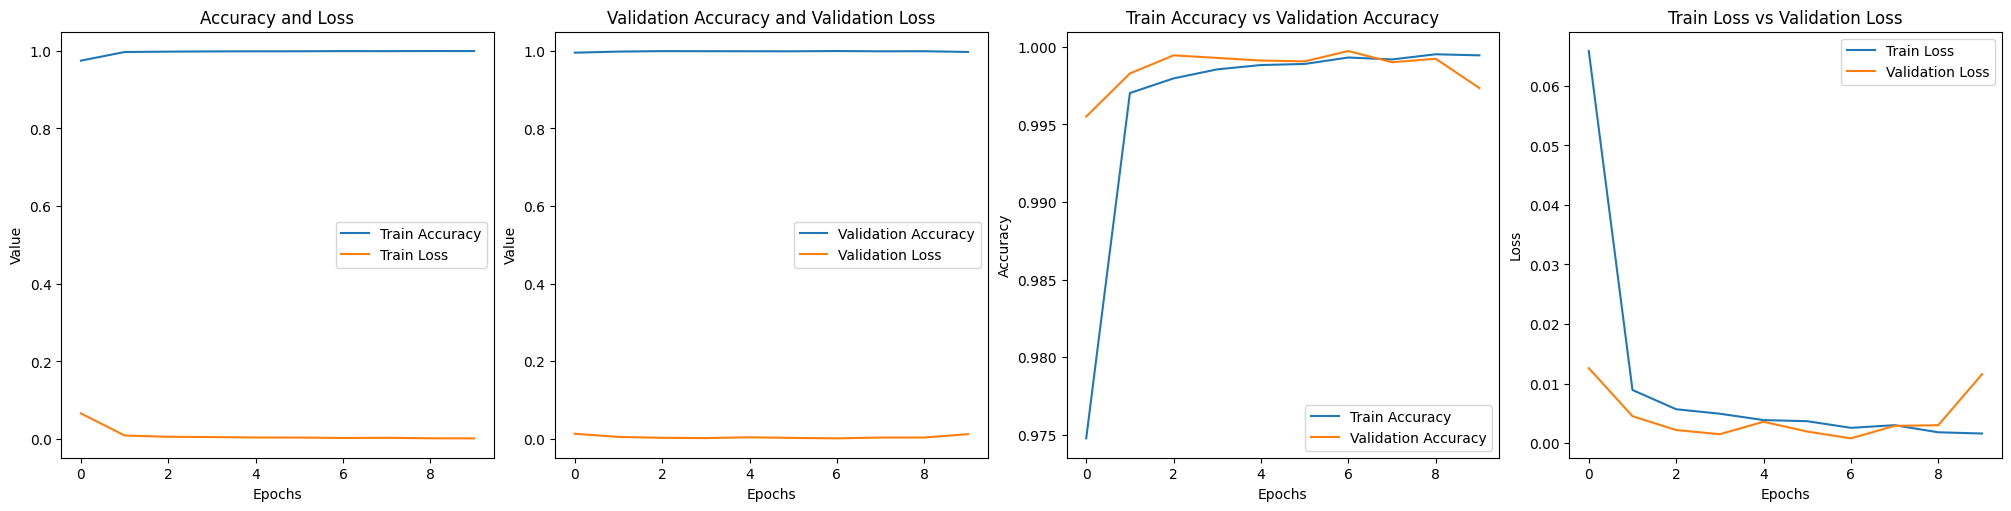

In [ ]:
# Set up ukuran dan letak grafik
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)

# 1. Accuracy and Loss
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].set_title('Accuracy and Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Value')
axes[0].legend()

# 2. Validation Accuracy and Validation Loss
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Validation Accuracy and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Value')
axes[1].legend()

# 3. Train Accuracy vs Validation Accuracy
axes[2].plot(history.history['accuracy'], label='Train Accuracy')
axes[2].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[2].set_title('Train Accuracy vs Validation Accuracy')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Accuracy')
axes[2].legend()

# 4. Train Loss vs Validation Loss
axes[3].plot(history.history['loss'], label='Train Loss')
axes[3].plot(history.history['val_loss'], label='Validation Loss')
axes[3].set_title('Train Loss vs Validation Loss')
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Loss')
axes[3].legend()

# Show the plots
plt.show()

Before continue to the next step, we need to merge `job_offer_df` with `company_df` so that we can call the company name that open job offer.
<br>
It will get the `name_company` data

In [ ]:
# Merge job_offer_df with company_df
job_offer_df = job_offer_df.merge(company_df[['id_company','name_company']], how='left', on='id_company')

##**7th Step: Show the Recomendation**
 Recommend the top job based on a candidate's desired skills and location.

 It tokenizes and pads the candidate's input, calculates similarity with existing jobs using the trained model, and prioritizes jobs with matching skills and locations for recommendation.


In [ ]:
# Define new job skills and location for comparison
new_job_skills = ["Color Theory", "Java"]
new_job_location = "Badung"

# Combine skills and location into a single text string for tokenization
new_job_text = " ".join(new_job_skills) + " " + new_job_location

# Tokenize the new job text and convert it into a sequence and
# Pad the tokenized sequence to match the maximum sequence length
new_job_sequence = tokenizer.texts_to_sequences([new_job_text])
new_job_padded = pad_sequences(new_job_sequence, maxlen=max_len, padding='post')

# Prepare arrays to store matching scores for jobs based on location, skills, and final result
location_and_skill_match_jobs = []
location_match_jobs = []
skill_match_jobs = []

# Prioritize jobs that match both location and skills
for idx, (existing_job_location, existing_job_skills, existing_job_position) in enumerate(zip(job_offer_df['regency_name'], job_offer_df['req_skill'], job_offer_df['position'])):
    # Combine the existing job's skills and location into a single text string
    existing_job_text = existing_job_skills + " " + existing_job_location

     # Tokenize and pad the existing job's skills and location
    existing_job_sequence = tokenizer.texts_to_sequences([existing_job_text])
    existing_job_padded = pad_sequences(existing_job_sequence, maxlen=max_len, padding='post')

    # Predict similarity score using the trained model
    similarity = model.predict([new_job_padded, existing_job_padded])
    similarity_score = similarity[0][0]

    # Check if the existing job contains at least one of the required skills
    has_required_skills = any(skill in existing_job_skills for skill in new_job_skills)

    # Assign scores based on location and skill match
    location_similarity_score = 1.0 if existing_job_location == new_job_location else 0.0
    skill_similarity_score = similarity_score if has_required_skills else 0.0  # Hanya menghitung jika skill sesuai

    # Prioritize jobs based on a combination of location and skills
    if location_similarity_score == 1.0 and skill_similarity_score > 0.7:
        final_score = 1.0  # Highest priority: Both location and skills match
    elif location_similarity_score == 1.0:
        final_score = 0.7 + 0.3 * skill_similarity_score  # Only location matches
    elif skill_similarity_score > 0.7:
        final_score = 0.3 + 0.7 * location_similarity_score  # Only skills match
    else:
        final_score = 0.0   # No match (neither location nor skills)

    # Store the matching result along with the score
    skill_match_jobs.append((existing_job_position, existing_job_location, existing_job_skills, final_score))

# Combine jobs and sort them based on the highest final scores
sorted_jobs = sorted(skill_match_jobs, key=lambda x: x[3], reverse=True)

# Select top jobs based on scores
top_jobs = sorted_jobs[:10] #Take 10 top jobs

# Display job recommendations
print(f"\nSkill: {new_job_skills}")
print(f"Loc: {new_job_location}\n")
print("Jobs recomendation based on the skill and regency:\n")
for idx, (position, location, skills, final_score) in enumerate(top_jobs):
    print(f"{idx+1}. {position} \nCompany: {job_offer_df.iloc[idx]['name_company']} - Location: {location} \n- Skill: {skills} \n- Accuration Score: {final_score:.4f}\n\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

As you can see there is list of recomendation of job offers based on the skill and user's regency with the accuration score

<br><br>

##**8th Step: Save the Model**
After done all of the step, save the model into `.h5` format.

In [ ]:
# 8. Menyimpan Model
model.save('job_recommendation_model.h5')
print("Model saved as 'job_recommendation_model.h5'")

Model saved as 'job_recommendation_model.h5'
